In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Load
path = "/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv"
data = pd.read_csv(path)


data=data.drop(columns=['Unnamed: 0','attacking_work_rate_encoded','defensive_work_rate_encoded'])
print(data.head())


   crossing  finishing  heading_accuracy  short_passing  volleys  dribbling  \
0        33         70                56             63     60.0         63   
1        67         67                57             66     69.0         80   
2        49         78                71             63     56.0         74   
3        51         42                75             68     42.0         47   
4        51         66                55             57     60.0         64   

   curve  free_kick_accuracy  long_passing  ball_control  ...  marking  \
0   55.0                  27            56            66  ...       23   
1   67.0                  73            58            77  ...       19   
2   45.0                  43            49            73  ...       20   
3   47.0                  41            67            62  ...       74   
4   50.0                  39            48            63  ...       15   

   standing_tackle  sliding_tackle  gk_diving  gk_handling  gk_kicking  \
0     

In [ ]:
#features-x , target y
y = data['player_role']
X = data.drop(columns=['player_role'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=8, random_state=42)

# BaggingClassifier with 200 trees and 80% sample per tree (just like in the attached file)
bagging = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=200,
    max_samples=0.8,
    n_jobs=-1,
    random_state=42
)

# Train the bagging ensemble
bagging.fit(X_train_scaled, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                   random_state=42),
                  max_samples=0.8, n_estimators=200, n_jobs=-1,
                  random_state=42)

In [ ]:
y_pred_bag = bagging.predict(X_test_scaled)


Bagging Accuracy: 98.78%

Bagging Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       420
           2       0.99      0.99      0.99       151
           3       0.99      1.00      1.00       159
           4       0.99      1.00      0.99      1067
           5       0.98      0.85      0.91        74
           6       0.86      0.90      0.88        61
           7       0.98      0.94      0.96        89

    accuracy                           0.99      2212
   macro avg       0.97      0.96      0.97      2212
weighted avg       0.99      0.99      0.99      2212



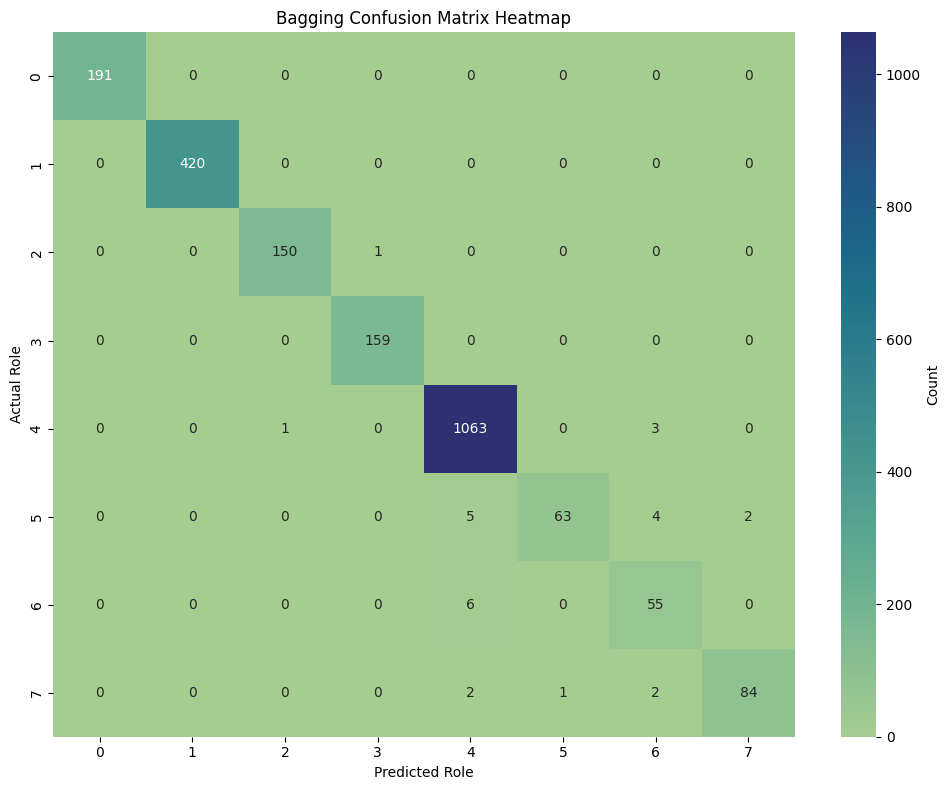

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_bag)
print(f"Bagging Accuracy: {accuracy * 100:.2f}%\n")

# Classification report
print("Bagging Classification Report:\n" + classification_report(y_test, y_pred_bag))

cm_bag = confusion_matrix(y_test, y_pred_bag, labels=bagging.classes_)
df_cm = pd.DataFrame(cm_bag, index=bagging.classes_, columns=bagging.classes_)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='crest', cbar_kws={'label': 'Count'})
plt.ylabel('Actual Role')
plt.xlabel('Predicted Role')
plt.title('Bagging Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()
print()


In [ ]:
pd.Series(y_pred_bag).to_csv('bagging_y_pred.csv', index=False)


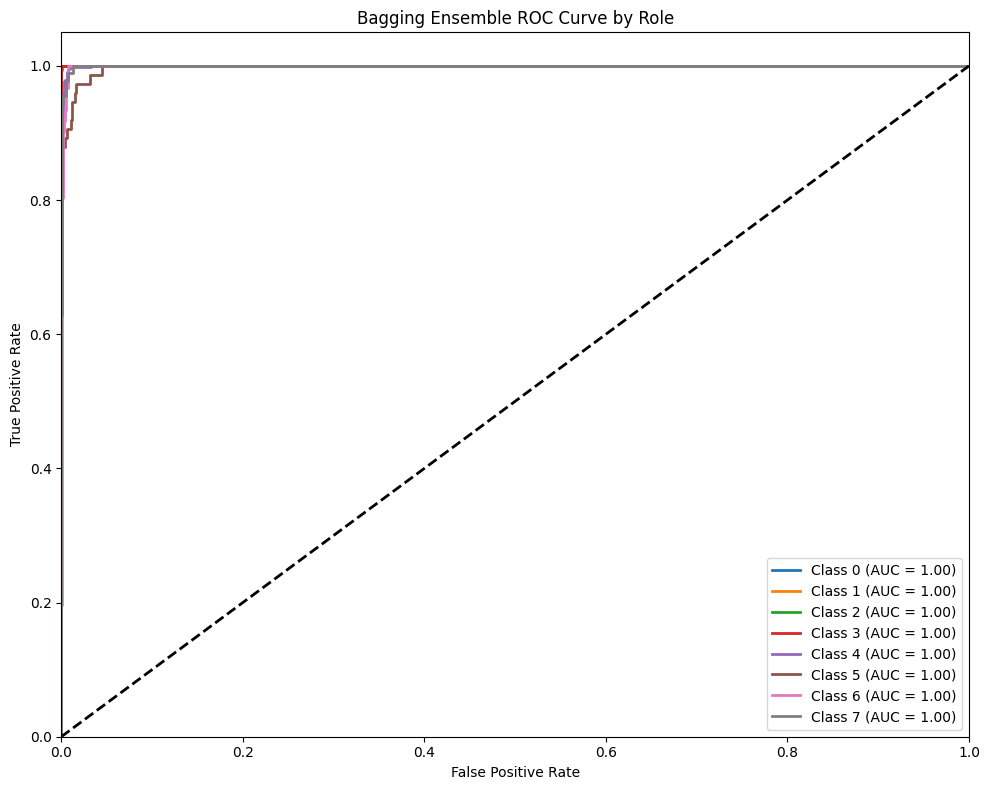

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probability estimates of shape (n_samples, n_classes)
probs_bag = bagging.predict_proba(X_test_scaled)

# Binarize the test labels
n_classes = len(bagging.classes_)
y_test_bin = label_binarize(y_test, classes=bagging.classes_)

plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs_bag[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {bagging.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging Ensemble ROC Curve by Role')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
